# Stakeholder

Apple as stakeholder and compare sentiment of its release vs. Google's at SXSW

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re

df = pd.read_csv('../data/tweets.csv', encoding = 'iso-8859-1')
sw = stopwords.words('english')

In [2]:
#Gets rid of company column
tweets = df.drop('emotion_in_tweet_is_directed_at', axis = 1)

In [3]:
tweets['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [4]:
#Drops rows with unknown sentiment
tweets = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product'] != 'I can\'t tell']

In [5]:
#Renames column with sentiments as label and drops single nan row
tweets['label'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product']
tweets = tweets.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1)
tweets = tweets.dropna()

In [6]:
tweets.label.value_counts(normalize = True)

No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: label, dtype: float64

In [7]:
#Reassigns label
tweets.label = tweets.label.map({'Negative emotion' : 0, 'Positive emotion': 1, 
                                 'No emotion toward brand or product': 2})

tweets.label.value_counts(normalize = True)

2    0.602954
1    0.333259
0    0.063787
Name: label, dtype: float64

In [8]:
#Functions to tokenize text
import string

def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
punct = list(string.punctuation)
#Keep periods for ellipses? They're the most common "word" though
#Keep numbers or get rid of them?
keep_punct = ['#', '?', '!', ',', '@']
punct = [p for p in punct if p not in keep_punct]
    
def tweet_tokenizer(doc, stop_words = sw):
    tweet_token = TweetTokenizer(strip_handles = True)
    doc = tweet_token.tokenize(doc)
    doc = [w for w in doc if w not in sw]
    doc = [w for w in doc if w not in punct]
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return doc

# Data Exploration

In [9]:
from nltk.probability import FreqDist

all_words = []
for tweet in tweets['tweet_text']:
    all_words.extend(tweet_tokenizer(tweet))


F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


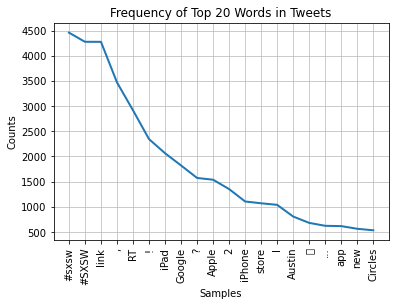

In [10]:
fdist = FreqDist()
for word in all_words:
    fdist[word] += 1
fdist.plot(20, title = 'Frequency of Top 20 Words in Tweets')
plt.show()

# Get rid of bad data

In [11]:
tweets['word_count'] = tweets['tweet_text'].apply(word_count)
tweets['word_count'].describe()

NameError: name 'word_count' is not defined

In [ ]:
tweets[tweets['word_count'] == 2]

In [ ]:
tweets = tweets[tweets['word_count'] != 2]

# Feature Creation

In [12]:
#Look for excessive puntuation
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

#Flag if at-ed the company

#Ratio capital to length tweet
def capital_letter_ratio(tweet):
    capital_count = 0
    for c in tweet:
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Repeating words
def any_repeats(tweet):
    if len(set(tweet.split())) < len(tweet.split()):
        return 1
    else:
        return 0 
    
#Hashtag count
def count_hash(tweet):
    hashtag = re.findall(r'(#w[A-Za-z0-9]*)', tweet)
    return len(hashtag)

#Average word length
def avg_length(tweet):
    char = len(tweet)
    word = len(tweet.split())
    return char / word

#Number of words
def word_count(tweet):
    return len(tweet.split())

In [13]:
tweets['punc_count'] = tweets['tweet_text'].apply(punc_count)
tweets['avg_word_len'] = tweets['tweet_text'].apply(avg_length)

In [14]:
tweets.avg_word_len.value_counts()

6.000000    292
5.000000    139
5.500000    131
7.000000    109
6.500000    101
           ... 
4.653846      1
4.545455      1
4.368421      1
4.967742      1
5.925926      1
Name: avg_word_len, Length: 808, dtype: int64

# Different Vectorizers

In [16]:
#Train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
col_labels = list(X_train.columns)
col_labels.remove('tweet_text')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

NameError: name 'X_train' is not defined

### CountVectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_cv = cv.fit_transform(X_train['tweet_text'])

#SCALE NON-VECTORIZED COLUMNS

X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_cv_df, X_train[col_labels]], axis=1)

NameError: name 'X_train' is not defined

### TF_IDF Vec

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train['tweet_text'])

#SCALE NON-VECTORIZED COLUMNS

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names(), index = X_train.index)
X_train_final = pd.concat([X_train_tfidf_df, X_train[col_labels]], axis=1)

NameError: name 'X_train' is not defined

# Models

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

first_pass = MultinomialNB()
first_pass.fit(X_train_final, y_train)
print("Training Score:", first_pass.score(X_train_final, y_train))
scores = np.mean(cross_val_score(first_pass, X_train_final, y_train, cv=5))
print("Validation Score:" + str(scores))

NameError: name 'X_train_final' is not defined

# IGNORE/TESTING AREA

## IF WANT TRY PIPELINE/ADD FEATURE THINGY

In [ ]:
"""
from sklearn.pipeline import FeatureUnion, Pipeline
count_vec = FeatureUnion([
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

tfidf_vec = FeatureUnion([
        ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
        #, add any feature creation things here
    ])

first_pass = Pipeline(steps=[
    ('vec', count_vec),
    ('mnb', MultinomialNB())
])
"""

In [20]:
def punc_count(tweet):
    punctuations = '!$%&()*+,-./:;<=>?[\]^_`{|}~'
    count = 0
    for p in punctuations:
        count += tweet.count(p)
    return count

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class PuncCount(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.apply(punc_count)

In [22]:
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

In [23]:
from sklearn.pipeline import FeatureUnion, Pipeline
count_vec = FeatureUnion([
        ('punc', PuncCount()),
        ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer))
    ])

first_pass = Pipeline(steps=[
    ('vec', count_vec),
    ('mnb', MultinomialNB())
])

first_pass.fit(X_train, y_train)
print("Training Score:", first_pass.score(X_train, y_train))
scores = np.mean(cross_val_score(first_pass, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 6702, expected 1.

In [24]:
pc = PuncCount()
pc.fit(X_train)
test = pc.transform(X_train)

# Getting only Apple Tweets

In [25]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [26]:
no_labels = df[df['emotion_in_tweet_is_directed_at'].isna()]
no_labels = no_labels.dropna(subset = ['tweet_text'])

In [27]:
tweet_list = []
for tweet in no_labels['tweet_text']:
    tweet_check = tweet.lower()
    if ('iphone' in tweet_check) or ('ipad' in tweet_check) or ('apple' in tweet_check):
        tweet_list.append(tweet)

In [28]:
ipad = df[df['emotion_in_tweet_is_directed_at'] == 'iPad']
apple = df[df['emotion_in_tweet_is_directed_at'] == 'Apple']
mix = df[df['emotion_in_tweet_is_directed_at'] == 'iPad or iPhone App']
iphone = df[df['emotion_in_tweet_is_directed_at'] == 'iPhone']
apps = df[df['emotion_in_tweet_is_directed_at'] == 'Other Apple product or service']

unlabeled_apple = df[df['tweet_text'].isin(tweet_list)]
unlabeled_apple = unlabeled_apple.drop_duplicates(subset = 'tweet_text')

final_df = pd.concat([ipad, apple, mix, iphone, apps, unlabeled_apple], axis = 0)

final_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
20,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive emotion
25,RT @LaurieShook: I'm looking forward to the #S...,iPad,Positive emotion
36,The best! RT @mention Ha! First in line for #...,iPad,Positive emotion
57,{link} RT @mention 1st stop on the #SXSW #Chao...,iPad,Positive emotion


In [29]:
final_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)

No emotion toward brand or product    0.519993
Positive emotion                      0.386466
Negative emotion                      0.075629
I can't tell                          0.017912
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [30]:
len(final_df)

5527

In [31]:
len(tweets) - len(final_df)

3409